In [1]:
import numpy as np
import matplotlib.pyplot as plt        

In [2]:
%%capture
from tvb.simulator.lab import *

In [3]:
from matplotlib.lines import Line2D

def phase_plane(
        model, 
        variables=None, 
        npoints=100, 
        state=None, 
        mode=0,
        title=None,
        square_aspect=False,
        faded=False,
        ax=None
):
    assert len(model.state_variables) > 1
    if ax is None:
        _, ax = plt.subplots(figsize=(10,8))

    if faded:
        color="lightgray"
        alpha=0.5
    else:
        color=None
        alpha=1

    if variables==None:
        svarx, svary = [0,1]
        variables = model.state_variables[:2]
    else:
        assert len(variables) == 2
        svarx = model.state_variables.index(variables[0])
        svary = model.state_variables.index(variables[1])

    if state is None:
        state = np.array([model.state_variable_range[key].mean() for key in model.state_variables])
        state = state[:,np.newaxis,np.newaxis]

    if title is None:
        title=model.__class__.__name__


    xlim = model.state_variable_range[variables[0]]
    ylim = model.state_variable_range[variables[1]]

    x = np.linspace( *xlim, npoints)
    y = np.linspace( *ylim, npoints)

    xx, yy = np.meshgrid(x,y)
    dx = np.zeros([len(y),len(x)])
    dy = np.zeros([len(y),len(x)])


    nocoupling = np.zeros(( model.nvar, 1, model.number_of_modes))
    for i in range(len(y)):
        for j in range(len(x)):
            state[svarx,0,:] = x[j]
            state[svary,0,:] = y[i]
            dstate = model.dfun(
                    state,
                    nocoupling
            )
            dx[i,j], dy[i,j] = dstate[[svarx,svary],0,mode]
    ax.streamplot(x,y,dx,dy,density=2.0,color=color)

    ax.set_xlabel(variables[0],fontsize=15.0)
    ax.set_ylabel(variables[1],fontsize=15.0)
    ax.contour(xx,yy,dx, [0], colors="r", alpha=alpha)
    ax.contour(xx,yy,dy, [0], colors="g", alpha=alpha)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    legend_elements = [
            Line2D([0], [0], color='r', alpha=alpha, label=f'$\dot {variables[0]}=0$'),
            Line2D([0], [0], color='g', alpha=alpha, label=f'$\dot {variables[1]}=0$'),
    ]
    ax.legend(handles=legend_elements,loc='upper right')
    ax.set_title(title)
    if square_aspect:
        ax.set_aspect(abs(xlim[0]-xlim[1])/abs(ylim[0]-ylim[1]))

    return ax

In [4]:
def configure_single_node_sim(
    model,
    initial_conditions=None,
    sim_len=100,
    deterministic=False,
    noise_sigma=0.01,
    dt=0.01,
):
    """ Configures a single node simulation.

    Parameters
    sim_len        length [ms] of simulation
    deterministic  no noise if set to True (default True)
    dt             integration step (default 0.01)

    Returns:
    sim            configured simulator instance
    """

    conn = connectivity.Connectivity()
    conn.weights=np.zeros((2,2))
    conn.tract_lengths=np.zeros((2,2))
    conn.centres=np.zeros((2,3))
    conn.number_of_regions=2
    conn.region_labels = np.array(["A","ignore"])

    con_coupling = coupling.Scaling()

    if deterministic:
        integrator = integrators.RungeKutta4thOrderDeterministic(dt=dt)
    else:
        nsigma = noise_sigma
        hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]))
        integrator = integrators.HeunStochastic(dt=dt, noise=hiss)

    mntrs = [monitors.Raw()]

    if initial_conditions is not None:
        initial_conditions = np.stack(
                [initial_conditions,initial_conditions],
                axis=1
        )[np.newaxis,:,:, np.newaxis]

    sim = simulator.Simulator(model=model,
                              connectivity=conn,
                              coupling=con_coupling,
                              integrator=integrator,
                              monitors=mntrs,
                              simulation_length=sim_len)
    if initial_conditions is not None:
        sim.initial_conditions = initial_conditions

    sim.configure()

    return sim

## MONTBRIO, PAZO, ROXIN 2015

Montbrió E, Pazó D, Roxin A. Macroscopic description for networks of spiking neurons. Physical Review X. 2015;5(2):21028.

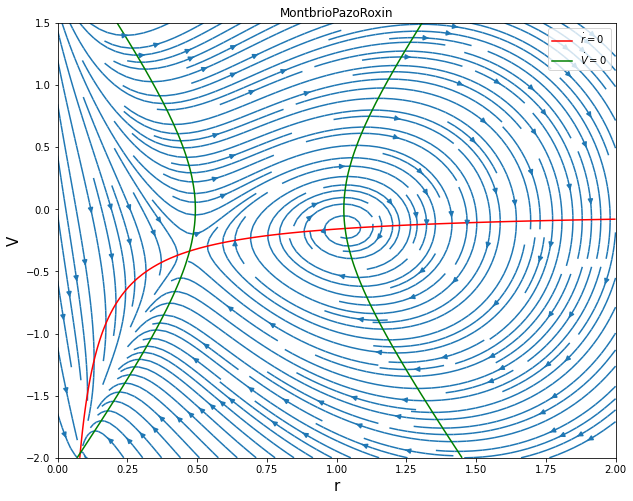

In [5]:
T2d = models.MontbrioPazoRoxin()
phase_plane(T2d);

In [6]:
sim = configure_single_node_sim(
    T2d, 
    sim_len=75,
    initial_conditions=np.r_[0,-2],
    deterministic=True
)

In [7]:
eqn_t = equations.Sinusoid()
eqn_t.parameters['amp'] = 3.
eqn_t.parameters['frequency'] = 1/40.
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(sim.connectivity.number_of_regions)
)

sim.stimulus = stimulus
sim.configure();

In [8]:
(raw_time, raw_data), = sim.run()

In [9]:
r = raw_data[:,0,0,0]
V = raw_data[:,1,0,0]

In [10]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

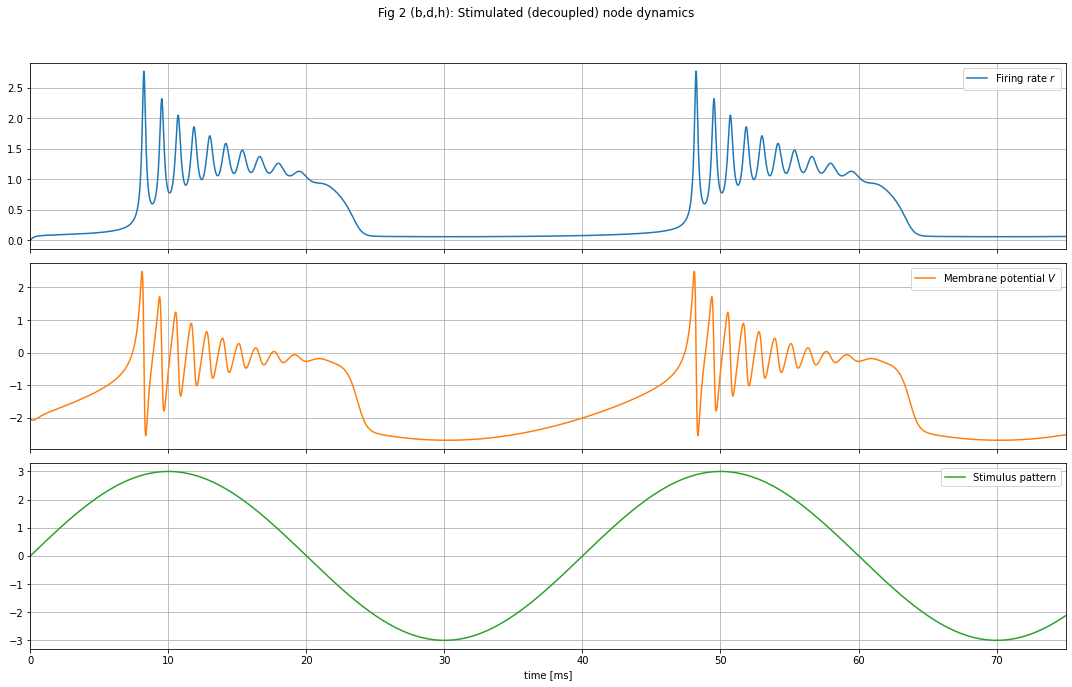

In [11]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
pattern = sim.stimulus.temporal_pattern[0]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, (var, label) in enumerate([(r,'Firing rate $r$'), (V,'Membrane potential $V$'), (pattern,'Stimulus pattern')]):
    ax = axs[i]
    ax.plot(raw_time, var, label=label, c=colors[i])
    ax.set_xlim((0,sim.simulation_length))
    ax.legend()
    ax.grid()
axs[-1].set_xlabel('time [ms]')

fig.suptitle('Fig 2 (b,d,h): Stimulated (decoupled) node dynamics')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## COOMBES, BYRNE, 2019

The model implementation in TVB was done in terms of $r$ and $V$ variable. Originally the system equations were written in terms of the Kuramoto parameter $Z$ (see eq.s (23)-(26)).

Coombes S, Byrne Á. Next generation neural mass models. In: Nonlinear Dynamics in Computational Neuroscience. Springer; 2019. pp. 1–16. (Nonlinear Dynamics in Computational Neuroscience).

In [12]:
COB = models.CoombesByrne(variables_of_interest=('r','V','g','q'))

In [13]:
sim = configure_single_node_sim(
    COB, 
    sim_len=200,
    deterministic=True,
)

In [14]:
(raw_time, raw_data), = sim.run()

In [15]:
r=raw_data[:,0,:,0]
V=raw_data[:,1,:,0]
g=raw_data[:,2,:,0]
q=raw_data[:,3,:,0]

In [16]:
def kuramoto_parameter(r,V):
    W = np.pi*r+1j*V
    Z = (1-np.conj(W))/(1+np.conj(W))
    return Z

In [17]:
Z = kuramoto_parameter(r,V)

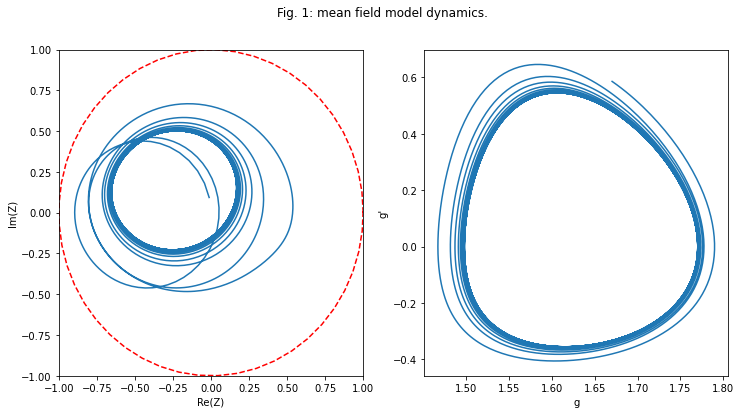

In [18]:
plt.figure(figsize=(12,6))
plt.suptitle('Fig. 1: mean field model dynamics.')
ax1= plt.subplot(121)
plt.plot(Z.real[:5000,0],Z.imag[:5000,0])
plt.xlabel('Re(Z)');plt.ylabel('Im(Z)'); plt.xlim(-1,1);plt.ylim(-1,1);x=np.linspace(0,6.3,50); plt.plot(np.cos(x),np.sin(x),'r--')
ax2=plt.subplot(122);plt.plot(g[600:5000,0],q[600:5000,0]);plt.xlabel('g');plt.ylabel('g\'')
ax1.set_aspect('auto');ax2.set_aspect('auto')

### 2D version

A 2D version of Coombes, Byrne, 2016 model is also implemented as `models.CoombesByrne2D`. This 2D model describes the dynamics of firing rate $r$ and membrane potential $V$ assuming that the conductance $g$ is proportional to the firing rate. This approximation consist in the limit of fast synaptic interaction where one can regard the operator $Q$ in equation (26) as trivial i.e., equal to the identity. For negative values of the parameter $k$ (negative conductance) one can find a limit cycle. 

<AxesSubplot:title={'center':'CoombesByrne2D'}, xlabel='r', ylabel='V'>

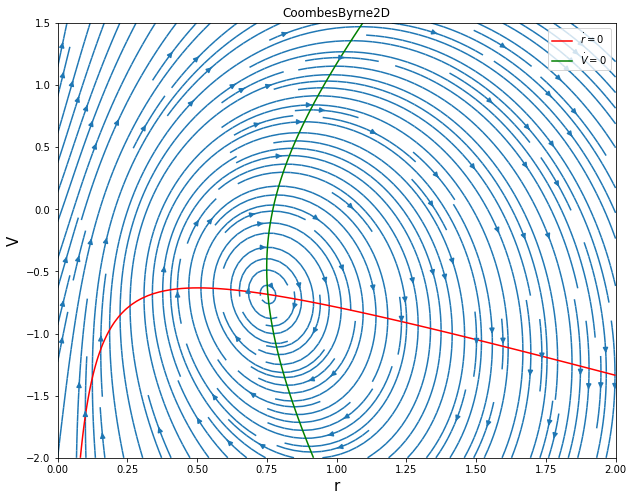

In [19]:
COB2 = models.CoombesByrne2D(k=np.array([-0.4]))
phase_plane(COB2)

In [20]:
sim = configure_single_node_sim(
    COB2, 
    sim_len=200,
    initial_conditions=np.r_[0.318,0],
    deterministic=True,
)

In [21]:
(raw_time, raw_data), = sim.run()

In [22]:
r=raw_data[:,0,:,0]
V=raw_data[:,1,:,0]

In [23]:
Z = kuramoto_parameter(r,V)

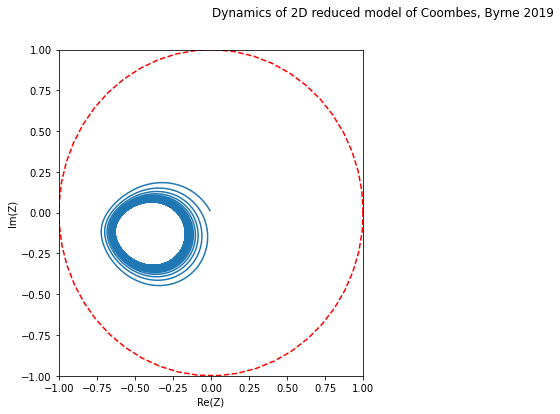

In [24]:
plt.figure(figsize=(12,6))
plt.suptitle('Dynamics of 2D reduced model of Coombes, Byrne 2019')
ax1= plt.subplot(121)
plt.plot(Z.real[:5000,0],Z.imag[:5000,0])
plt.xlabel('Re(Z)');plt.ylabel('Im(Z)'); plt.xlim(-1,1);plt.ylim(-1,1);x=np.linspace(0,6.3,50); plt.plot(np.cos(x),np.sin(x),'r--')
ax1.set_aspect('auto');

## GAST, SCHMIDT, KNOSCHE, 2019 - ADAPTATION SYNAPTIC DEPRESSION

Gast R, Schmidt H, Knösche T R. A mean-field description of bursting dynamics in spiking neural networks with short-term adaptation. Neural Computation. 2020;32(9):1615–1634.

In [25]:
nta=-6.0
SDM = models.GastSchmidtKnosche_SD(eta=np.array([nta]))

In [26]:
sim = configure_single_node_sim(
    SDM, 
    sim_len=500,
    deterministic=True,
    initial_conditions=np.r_[0.75,0.,0.,0.],
    dt = 0.025
)

SDM.stvar=np.r_[1] # stimulate the membrane potential

eqn_t = equations.PulseTrain()
eqn_t.parameters['amp'] = 0.5
eqn_t.parameters['T'] = 400.
eqn_t.parameters['tau'] = 200.
eqn_t.parameters['onset'] = 100.

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(
        sim.connectivity.number_of_regions
    )
)

sim.stimulus = stimulus
sim.configure();

In [27]:
(raw_time, raw_data), = sim.run()

In [28]:
r=raw_data[:,0,0,0]
V=raw_data[:,1,0,0]

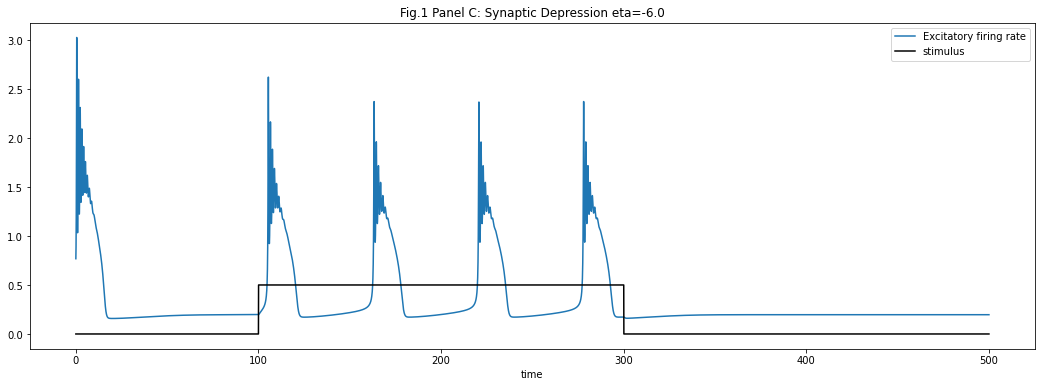

In [29]:
plt.figure(figsize=(18,6))
plt.title('Fig.1 Panel C: Synaptic Depression eta=%.1f'%nta)
plt.plot(raw_time,r,label='Excitatory firing rate')
plt.xlabel('time')
pattern = sim.stimulus.temporal_pattern[0]
plt.plot(raw_time, pattern, 'k',label='stimulus')
plt.legend();

In [30]:
nta=-4.0
SDM = models.GastSchmidtKnosche_SD(eta=np.array([nta]))

In [31]:
sim = configure_single_node_sim(
    SDM, 
    sim_len=500,
    deterministic=True,
    initial_conditions=np.r_[0.75,0.,0.,0.],
    dt = 0.025
)

SDM.stvar=np.r_[1] # stimulate the membrane potential

eqn_t = equations.PulseTrain()
eqn_t.parameters['amp'] = -1.5
eqn_t.parameters['T'] = 400.
eqn_t.parameters['tau'] = 200.
eqn_t.parameters['onset'] = 100.

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(
        sim.connectivity.number_of_regions
    )
)

sim.stimulus = stimulus
sim.configure();

In [32]:
(raw_time, raw_data), = sim.run()

In [33]:
r=raw_data[:,0,0,0]
V=raw_data[:,1,0,0]

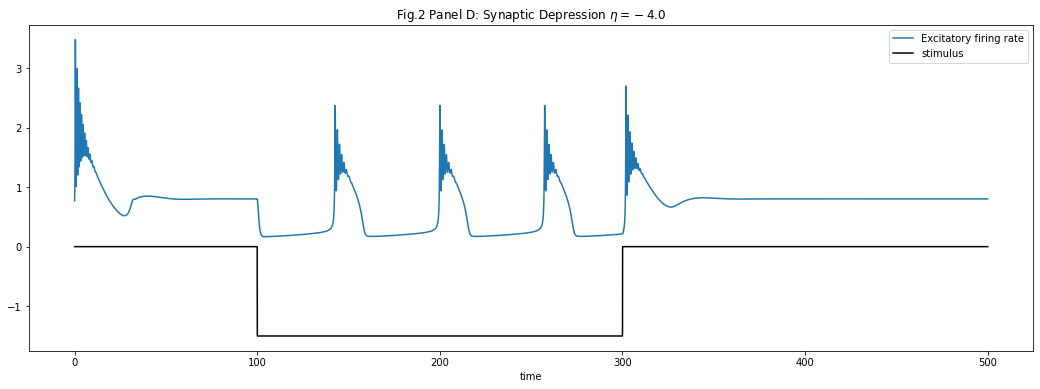

In [34]:
plt.figure(figsize=(18,6))
plt.title('Fig.2 Panel D: Synaptic Depression $\eta=%.1f$'%nta)
plt.plot(raw_time,r,label='Excitatory firing rate')
plt.xlabel('time')
pattern = sim.stimulus.temporal_pattern[0]
plt.plot(raw_time, pattern, 'k',label='stimulus')
plt.legend();

In [35]:
nta=-4.6
SDM = models.GastSchmidtKnosche_SD(eta=np.array([nta]))

In [36]:
sim = configure_single_node_sim(
    SDM, 
    sim_len=500,
    deterministic=True,
    initial_conditions=np.r_[0.75,0.,0.,0.],
    dt = 0.025
)

SDM.stvar=np.r_[1] # stimulate the membrane potential

eqn_t = equations.PulseTrain()
eqn_t.parameters['amp'] = 0.2
eqn_t.parameters['T'] = 400.
eqn_t.parameters['tau'] = 80.
eqn_t.parameters['onset'] = 170.

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(
        sim.connectivity.number_of_regions
    )
)

sim.stimulus = stimulus
sim.configure();

In [37]:
(raw_time, raw_data), = sim.run()

In [38]:
r=raw_data[:,0,0,0]
V=raw_data[:,1,0,0]

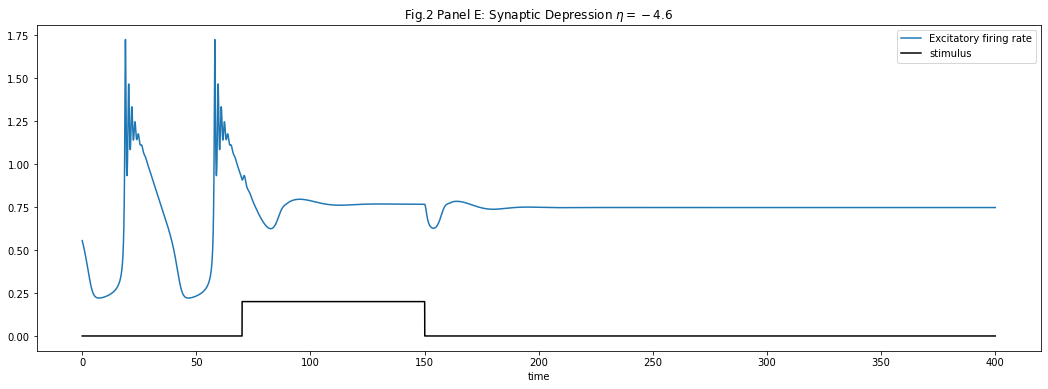

In [39]:
offset = int(100/sim.integrator.dt)
plt.figure(figsize=(18,6))
plt.title('Fig.2 Panel E: Synaptic Depression $\eta=%.1f$'%nta)
plt.plot(raw_time[offset:]-100,r[offset:],label='Excitatory firing rate')
plt.xlabel('time')
pattern = sim.stimulus.temporal_pattern[0]
plt.plot(raw_time[offset:]-100, pattern[offset:], 'k',label='stimulus')
plt.legend();

## GAST, SCHMIDT, KNOSCHE, 2019 -  SPIKE-FREQUENCY ADAPTATION

In [40]:
SDM = models.GastSchmidtKnosche_SF()

In [41]:
sim = configure_single_node_sim(
    SDM, 
    sim_len=500,
    deterministic=True,
    initial_conditions=np.r_[0.75,0.,0.,0.],
    dt = 0.025
)

SDM.stvar=np.r_[1] # stimulate the membrane potential

eqn_t = equations.PulseTrain()
eqn_t.parameters['amp'] = 1.5
eqn_t.parameters['T'] = 400.
eqn_t.parameters['tau'] = 90.
eqn_t.parameters['onset'] = 142.

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(
        sim.connectivity.number_of_regions
    )
)

sim.stimulus = stimulus
sim.configure();

In [42]:
(raw_time, raw_data), = sim.run()

In [43]:
r=raw_data[:,0,0,0]
V=raw_data[:,1,0,0]

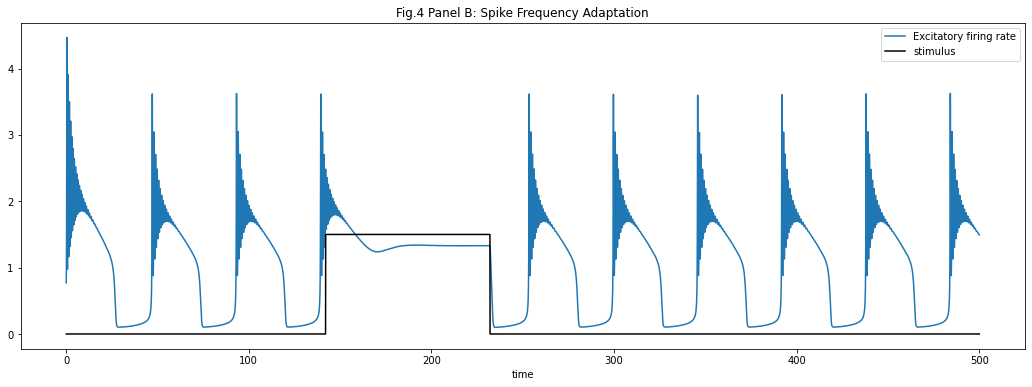

In [44]:
plt.figure(figsize=(18,6))
plt.title('Fig.4 Panel B: Spike Frequency Adaptation')
plt.plot(raw_time,r,label='Excitatory firing rate')
plt.xlabel('time')
pattern = sim.stimulus.temporal_pattern[0]
plt.plot(raw_time, pattern, 'k',label='stimulus')
plt.legend();

## DUMONT, GUTKIN, 2019

Dumont G, Gutkin B. Macroscopic phase resetting-curves determine oscillatory coherence and signal transfer in inter-coupled neural circuits. PLoS computational biology. 2019;15(5):e1007019.

In [45]:
DGM = models.DumontGutkin(
    J_ee=np.array([0.]),
    J_ei=np.array([15.]),
    J_ie=np.array([15.]),
    J_ii=np.array([0.]),
    variables_of_interest=('r_e','V_e','r_i','V_i')
)

In [46]:
sim = configure_single_node_sim(
    DGM, 
    sim_len=200,
    deterministic=True,
    dt=0.005
)

eqn_t = equations.PulseTrain()
eqn_t.parameters['amp'] = 10.
eqn_t.parameters['T'] = 100.
eqn_t.parameters['tau'] = 100.
eqn_t.parameters['onset'] = 20.

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(
        sim.connectivity.number_of_regions
    )
)
DGM.stvar=np.r_[1] # stimulate the membrane potential

sim.stimulus = stimulus
sim.configure();

In [47]:
(raw_time, raw_data), = sim.run()

In [48]:
r_e=raw_data[:,0,:,0]
V_e=raw_data[:,1,:,0]
r_i=raw_data[:,2,:,0]
V_i=raw_data[:,3,:,0]

Model prediction of Fig.2 Panel D. The model converges to spiking neural net dynamics some cycles after stimulus onset.

<function matplotlib.pyplot.show(close=None, block=None)>

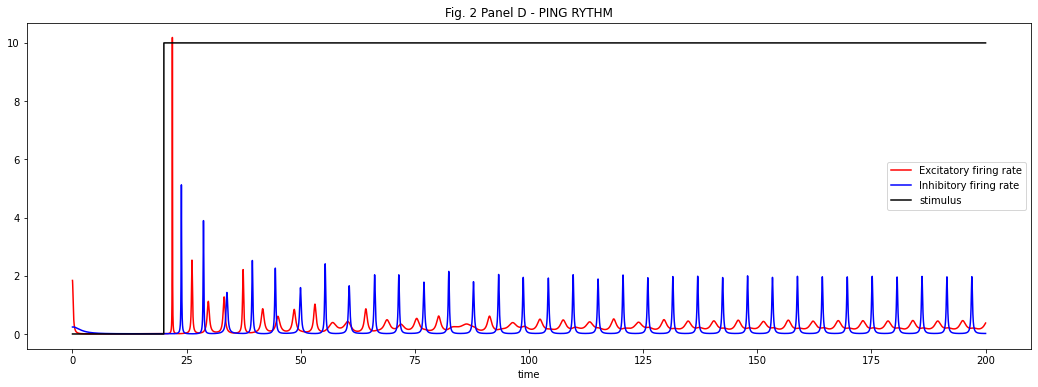

In [49]:
plt.figure(figsize=(18,6))
plt.plot(raw_time,r_e[:,0],'r',label='Excitatory firing rate')
plt.plot(raw_time,r_i[:,0],'b',label='Inhibitory firing rate')
pattern = sim.stimulus.temporal_pattern[0]
plt.plot(raw_time, pattern, 'k',label='stimulus')
plt.legend(); plt.title('Fig. 2 Panel D - PING RYTHM');plt.xlabel('time'); plt.show

In [50]:
DGM = models.DumontGutkin(
    J_ee=np.array([0.]),
    J_ei=np.array([10.]),
    J_ie=np.array([0.]),
    J_ii=np.array([15.]),
    variables_of_interest=('r_e','V_e','r_i','V_i')
)

In [51]:
sim = configure_single_node_sim(
    DGM, 
    sim_len=200,
    deterministic=True,
    dt=0.005
)

eqn_t = equations.PulseTrain()
eqn_t.parameters['amp'] = 25.
eqn_t.parameters['T'] = 100.
eqn_t.parameters['tau'] = 100.
eqn_t.parameters['onset'] = 20.

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(
        sim.connectivity.number_of_regions
    )
)
DGM.stvar=np.r_[1,5] 

sim.stimulus = stimulus
sim.configure();

In [52]:
(raw_time, raw_data), = sim.run()

In [53]:
r_e=raw_data[:,0,:,0]
V_e=raw_data[:,1,:,0]
r_i=raw_data[:,2,:,0]
V_i=raw_data[:,3,:,0]

Model prediction of Fig.3 Panel D. The model converges to spiking neural net dynamics some cycles after stimulus onset.

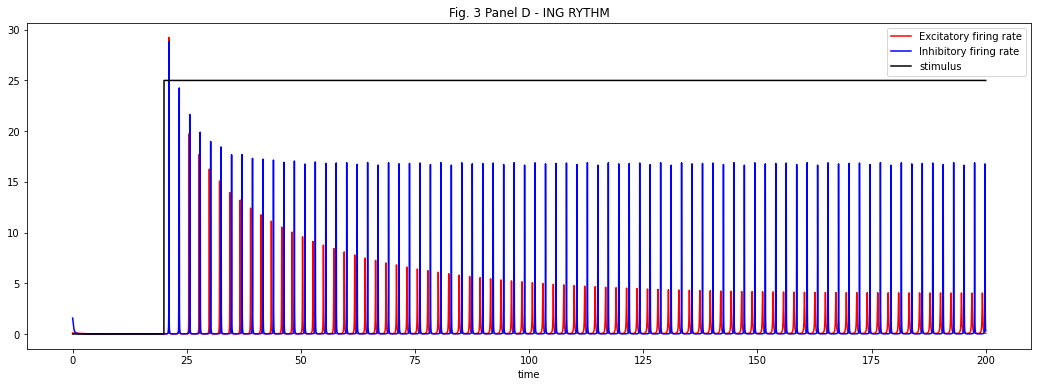

In [54]:
plt.figure(figsize=(18,6))
plt.plot(raw_time,r_e[:,0],'r',label='Excitatory firing rate')
plt.plot(raw_time,r_i[:,0],'b',label='Inhibitory firing rate')
pattern = sim.stimulus.temporal_pattern[0]
plt.plot(raw_time, pattern, 'k',label='stimulus')
plt.legend(); plt.title('Fig. 3 Panel D - ING RYTHM');plt.xlabel('time');